# Lognormal distributions of income among the employed by demographics

There's some tradition of using lognormal distributions for income, even though they are
known to not fit well at the lowest incomes. See http://www.statlit.org/pdf/2018-Schield-ASA.pdf.
Sometimes Pareto upper tails are used because this fits a little better at high incomes,
but we haven't done that here for simplicity.

The decision of how to define "income" is a difficult one without an obvious right answer.
In our simulation, we say that people who are unemployed have 0 income, which implies that
what we mean by income is really *wages* (income from employment).
However, we also use the "income" characteristic to determine who files taxes, which would be
based on total income from all sources, not only wages (actually AGI, but the differences are
too complicated to model).
Given this, I've chosen to use **total** income here (among the employed population).

As far as tax filing, we effectively presume that the unemployed never make enough total income
to file taxes.

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Sat Nov 19 08:11:15 PST 2022


## Read PUMS

In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[['SERIALNO', 'HISP', 'RAC1P', 'AGEP', 'SEX', 'PINCP', 'ADJINC', 'ESR', 'PWGTP']].reset_index(drop=True)

### Define demographics

In [4]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [5]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [6]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [7]:
assert np.all((acs.ADJINC / 1e6) >= 1)
assert np.all((acs.ADJINC / 1e6) <= 1.5)
acs['income_2020_dollars'] = acs.PINCP * (acs.ADJINC / 1e6)

In [8]:
acs_employed = acs[(acs.AGEP >= 18) & (acs.ESR.isin([1, 2, 4, 5]))].copy()
acs_employed

,SERIALNO,HISP,RAC1P,AGEP,SEX,PINCP,ADJINC,ESR,PWGTP,race_ethnicity,sex,age_group,income_2020_dollars
1,2016000000022,1,2,58,2,5900.0,1086849,1.0,48,Black,Female,"[50, 60)",6412.4091
2,2016000000022,1,2,62,1,140000.0,1086849,1.0,62,Black,Male,"[60, 70)",152158.8600
4,2016000000040,1,1,31,2,8800.0,1086849,1.0,17,White,Female,"[30, 40)",9564.2712
6,2016000000065,1,1,36,1,15300.0,1086849,1.0,4,White,Male,"[30, 40)",16628.7897
7,2016000000065,1,1,34,2,29700.0,1086849,1.0,5,White,Female,"[30, 40)",32279.4153
11,2016000000225,1,1,29,2,29100.0,1086849,1.0,28,White,Female,"[25, 30)",31627.3059
14,2016000000241,1,1,61,2,36000.0,1086849,1.0,46,White,Female,"[60, 70)",39126.5640
15,2016000000248,1,1,25,1,55000.0,1086849,1.0,6,White,Male,"[25, 30)",59776.6950
17,2016000000268,1,1,49,1,120000.0,1086849,1.0,36,White,Male,"[40, 50)",130421.8800
18,2016000000272,1,2,31,1,30000.0,1086849,1.0,53,Black,Male,"[30, 40)",32605.4700


In [9]:
%%time
# A lot of these methods are easier to use without weights, so we expand the dataframe out using the weights
# This is a really inefficient approach memory-wise, but it makes things easy to work with...
acs_employed_expanded = pd.DataFrame(np.repeat(acs_employed.values, acs_employed.PWGTP, axis=0), columns=acs_employed.columns).drop(columns=['PWGTP'])
acs_employed_expanded

CPU times: user 3min 4s, sys: 45.6 s, total: 3min 49s
Wall time: 3min 49s


,SERIALNO,HISP,RAC1P,AGEP,SEX,PINCP,ADJINC,ESR,race_ethnicity,sex,age_group,income_2020_dollars
0,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
1,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
2,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
3,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
4,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
5,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
6,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
7,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
8,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091
9,2016000000022,1,2,58,2,5900.0,1086849,1.0,Black,Female,"[50, 60)",6412.4091


In [10]:
acs_employed_expanded.income_2020_dollars = acs_employed_expanded.income_2020_dollars.astype(float)

In [11]:
def plot_histograms(values, max_values_to_plot=[None, 250_000], bins=50):
    for max_to_plot in max_values_to_plot:
        if max_to_plot is None:
            max_to_plot = values.max()
        plt.hist(values[values <= max_to_plot], density=True, bins=bins)
        plt.show()

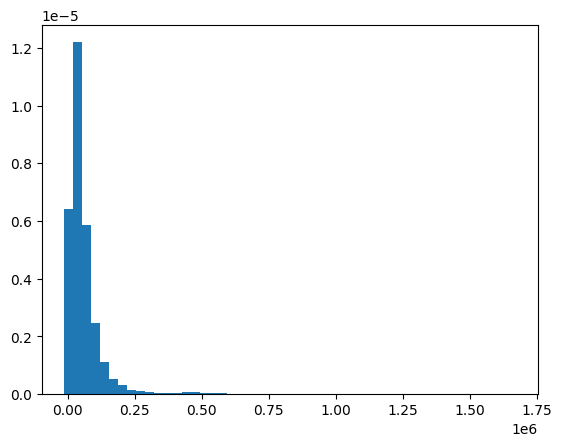

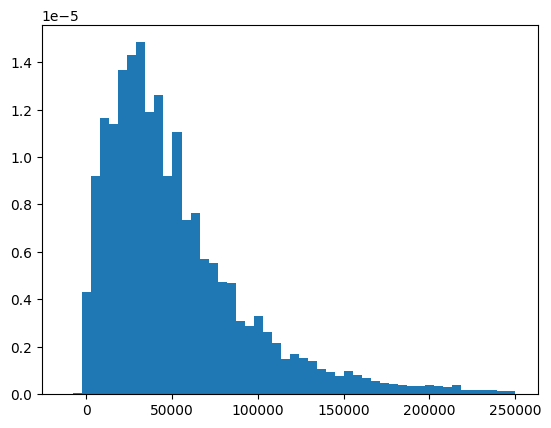

In [12]:
plot_histograms(acs_employed_expanded.income_2020_dollars)

## Fitting a lognormal distribution

### Approach 1: Fitting to all data points

Upside of this approach: uses the information from the full distribution.

Downsides of this approach: it cannot handle values <= 0 and is sensitive to how you clip these; will be thrown off by the use of top- and bottom-coding in the data.

In [13]:
def plot_pdfs(values, param_sets, max_values_to_plot=[None, 250_000], labels=None, bins=50, legend=True, style=None, pdf_alpha=1):
    if labels is None:
        labels = [f'shape={params[0]:,.2f}, scale={params[2]:,.2f}' for params in param_sets]
    for max_to_plot in max_values_to_plot:
        if max_to_plot is None:
            max_to_plot = values.max()
        x = np.linspace(0, max_to_plot, 1_000)
        pdfs = [stats.lognorm.pdf(x, params[0], loc=params[1], scale=params[2]) for params in param_sets]
        for pdf, label in zip(pdfs, labels):
            if style is not None:
                plt.plot(x, pdf, style, label=label, alpha=pdf_alpha)
            else:
                plt.plot(x, pdf, label=label, alpha=pdf_alpha)
        plt.hist(values[values <= max_to_plot], density=True, bins=bins, alpha=0.3)
        if legend:
            plt.legend()
        plt.show()

In [14]:
def plot_fitted_pdfs_by_clip(values, clip_values, **kwargs):
    param_sets = [stats.lognorm.fit(values.clip(lower=c), floc=0) for c in clip_values]
    labels = [f'clip <0 to {clip_value:,.2f}' for clip_value in clip_values]
    plot_pdfs(values, param_sets, labels=labels, **kwargs)

In [15]:
def plot_pdf(values, params, label=None, **kwargs):
    plot_pdfs(values, [params], labels=(None if label is None else [label]), **kwargs)

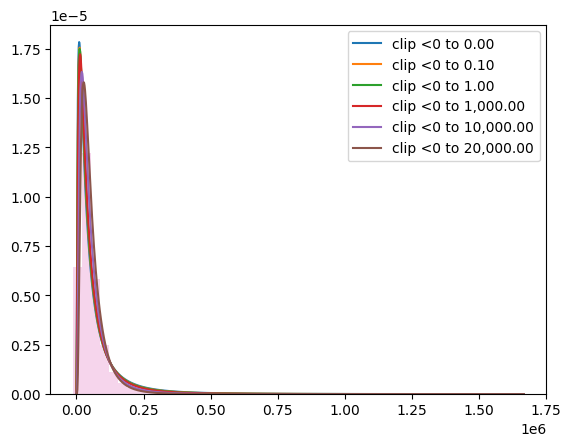

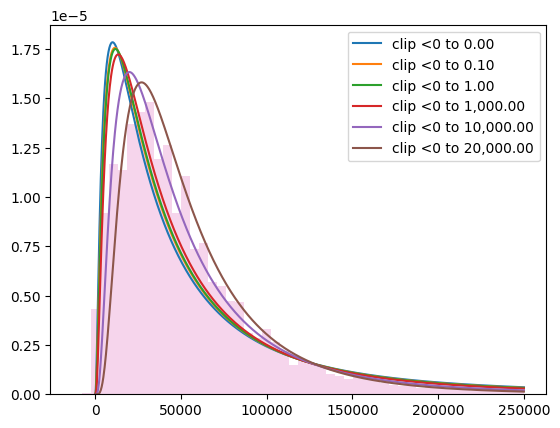

In [16]:
plot_fitted_pdfs_by_clip(acs_employed_expanded.income_2020_dollars, [0.0001, 0.1, 1, 1_000, 10_000, 20_000])

### Approach 2: Using mean and median

This is commonly used by economists apparently: http://www.statlit.org/pdf/2018-Schield-ASA.pdf.
I am not sure whether it is provably optimal by any metric of fit, in the absence of assuming
that the underlying distribution is truly lognormal.

It has the advantage of not requiring an arbitrary decision on what to do about values < 0.

I've verified that it is valid to calculate the mean even in the presence of top-coding:
"all top coded variables are top coded using the state mean of all cases greater than or equal to the top code state threshold value."
(https://www2.census.gov/programs-surveys/acs/tech_docs/pums/top_coded_values/2020PUMS_top_coded_values.pdf)

In [17]:
def params_from_mean_median(values, clip_invalid_ratios=False):
    # How the scipy params map to mu and sigma: https://stackoverflow.com/questions/8747761/scipy-lognormal-distribution-parameters
    mean = values.mean()
    median = values.median()

    if mean < median:
        if clip_invalid_ratios:
            mean = median
        else:
            raise ValueError(f"mean must be greater than or equal to median! {mean}, {median}")

    sigma = np.sqrt(2*np.log(mean/median))
    return (sigma, 0.0, median)

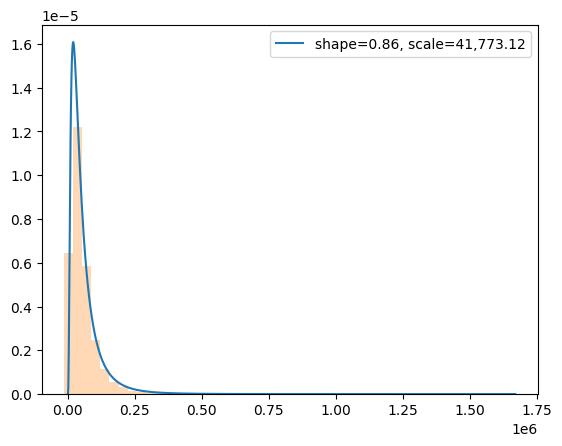

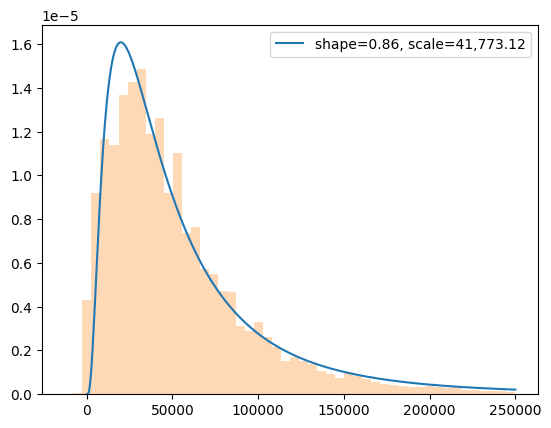

In [18]:
plot_pdf(acs_employed_expanded.income_2020_dollars, params_from_mean_median(acs_employed_expanded.income_2020_dollars))

## Unsmoothed result

In [19]:
%%time
means = acs_employed_expanded.groupby(['age_group', 'sex', 'race_ethnicity']).income_2020_dollars.mean()
medians = acs_employed_expanded.groupby(['age_group', 'sex', 'race_ethnicity']).income_2020_dollars.median()

CPU times: user 7min 44s, sys: 58.8 s, total: 8min 42s
Wall time: 8min 42s


In [20]:
result = pd.DataFrame({
    'mean': means,
    'median': medians,
    'mean_median_ratio': means / medians,
    's': np.sqrt(np.log(means / medians) * 2),
    'scale': medians,
})

In [21]:
result

mean      median  \
age_group sex    race_ethnicity                                    
[18, 19)  Female AIAN                    9905.956273   6136.5300   
                 Asian                   6742.372581   3681.9180   
                 Black                   8161.367681   5216.8752   
                 Latino                  8780.746770   5533.8195   
                 Multiracial or Other    7897.435684   4909.2240   
                 NHOPI                  10291.744032   5434.2450   
                 White                   6992.354274   4999.5054   
          Male   AIAN                   10072.363987   6443.3565   
                 Asian                   7555.274025   4225.8258   
                 Black                   8045.490068   5338.8550   
...                                              ...         ...   
[80, 100) Female Multiracial or Other   47844.031745  33202.9170   
                 NHOPI                  39319.452785  38909.1942   
                 White                  56580.500917  37227.5130   
          Male   AIAN                   61618.743475  43467.0875   
                 Asian                  98288.966696  56164.7546   
                 Black                  64237.859683  47046.7300   
                 Latino                 84804.856499  41250.9560   
                 Multiracial or Other   98125.068783  60368.9400   
                 NHOPI                  35875.134796  25946.8353   
                 White                 108129.329445  60444.8205   

                                       mean_median_ratio         s       scale  
age_group sex    race_ethnicity                                                 
[18, 19)  Female AIAN                           1.614260  0.978649   6136.5300  
                 Asian                          1.831212  1.099980   3681.9180  
                 Black                          1.564417  0.946058   5216.8752  
                 Latino                         1.586743  0.960920   5533.8195  
                 Multiracial or Other           1.608693  0.975113   4909.2240  
                 NHOPI                          1.893868  1.130152   5434.2450  
                 White                          1.398609  0.819119   4999.5054  
          Male   AIAN                           1.563217  0.945247   6443.3565  
                 Asian                          1.787881  1.077990   4225.8258  
                 Black                          1.506969  0.905649   5338.8550  
...                                                  ...       ...         ...  
[80, 100) Female Multiracial or Other           1.440959  0.854762  33202.9170  
                 NHOPI                          1.010544  0.144836  38909.1942  
                 White                          1.519857  0.915004  37227.5130  
          Male   AIAN                           1.417595  0.835419  43467.0875  
                 Asian                          1.750012  1.057944  56164.7546  
                 Black                          1.365405  0.789242  47046.7300  
                 Latino                         2.055828  1.200565  41250.9560  
                 Multiracial or Other           1.625423  0.985665  60368.9400  
                 NHOPI                          1.382640  0.804978  25946.8353  
                 White                          1.788893  1.078515  60444.8205  

[168 rows x 5 columns]

In [22]:
def add_age_bounds(df):
    df = df.copy()
    age_bound_cols = ['age_start', 'age_end']
    df[['age_start', 'age_end']] = [[x.left, x.right] for x in df['age_group']]
    
    return df[age_bound_cols + [c for c in df.columns if c not in age_bound_cols]].copy()

In [23]:
def add_age_midpoint(df):
    if 'age_start' not in df.columns or 'age_end' not in df.columns:
        df = add_age_bounds(df)
    df['age_midpoint'] = np.average(df[['age_start', 'age_end']], axis=1)
    
    return df

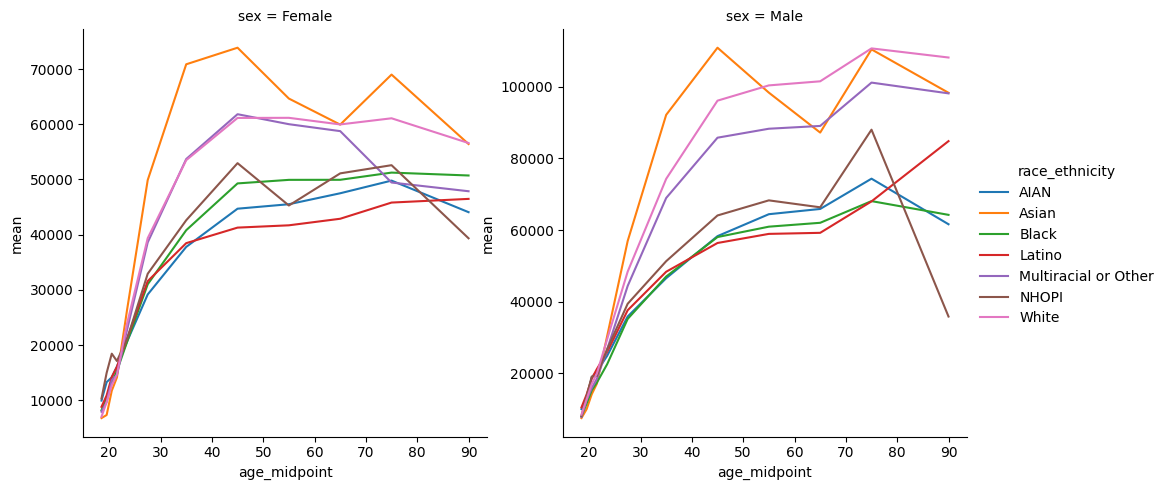

In [24]:
sns.relplot(
    data=add_age_midpoint(result.reset_index()),
    x="age_midpoint", y='mean',
    hue="race_ethnicity",
    col="sex",
    kind="line",
    facet_kws={'sharey': False, 'sharex': True}
)

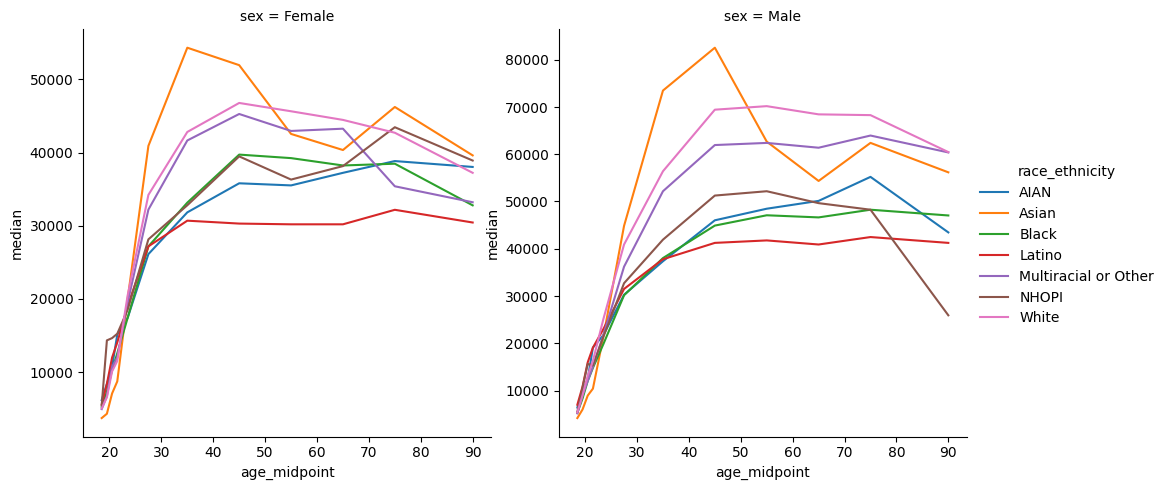

In [25]:
sns.relplot(
    data=add_age_midpoint(result.reset_index()),
    x="age_midpoint", y='median',
    hue="race_ethnicity",
    col="sex",
    kind="line",
    facet_kws={'sharey': False, 'sharex': True}
)

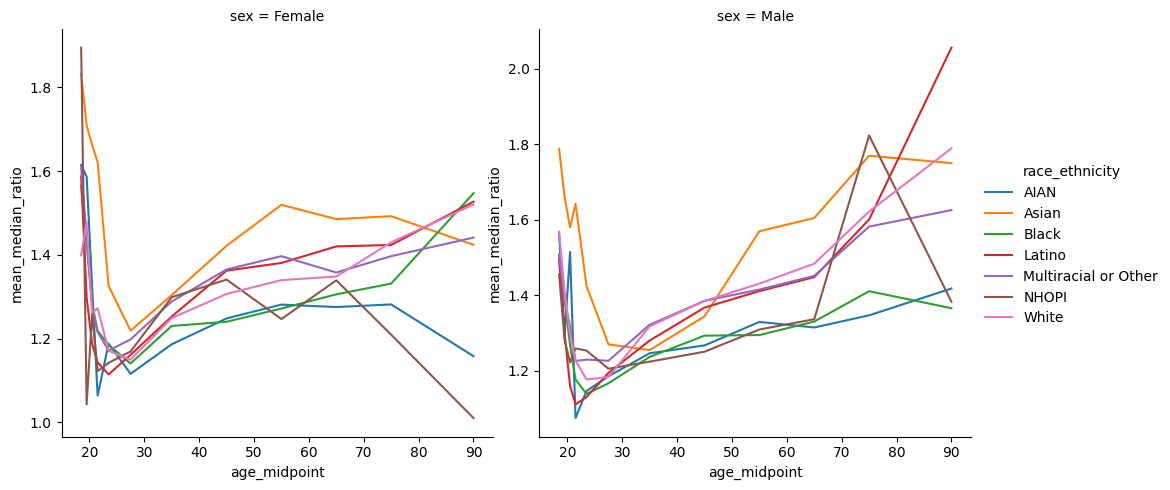

In [26]:
sns.relplot(
    data=add_age_midpoint(result.reset_index()),
    x="age_midpoint", y='mean_median_ratio',
    hue="race_ethnicity",
    col="sex",
    kind="line",
    facet_kws={'sharey': False, 'sharex': True}
)

In [27]:
def format_distribution_parameters_for_file(distribution_parameters):
    distribution_parameters = distribution_parameters[['s', 'scale']].reset_index()

    return add_age_bounds(distribution_parameters).drop(columns=['age_group'])

In [28]:
format_distribution_parameters_for_file(result).to_csv('sim_inputs/income_scipy_lognorm_distribution_parameters.csv', index=False, float_format='%f')

## Person-specific vs job-specific variance breakdown estimation

We have chosen to model income **in each demographic group** as follows:

$$log(income) \sim Normal(\mu_\text{log(income)}, \sigma_\text{log(income)}^2)$$

We want to break down the variance using two normally distributed components of income propensity:

$$job \sim Normal(0, \sigma_\text{job}^2)$$
$$simulant \sim Normal(0, 1-\sigma_\text{job}^2)$$

$$log(income) = F_\text{log(income)}(probit(job + simulant)) = (job + simulant) * \sigma_\text{log(income)} + \mu_\text{log(income)}$$

The empirical value we have is the variance of the 1-year change in log(earnings) for people who were employed in both years: https://www.irs.gov/pub/irs-soi/19rpincomevolatilitytaxationandlabor.pdf. The value is roughly (read from the graph) **0.09**.

We will assume that this value has not changed since 2015, is the same for income, and that it is about individuals (it is pretty hard to tell from that graph whether it is individual or household).

In our model of income,

$$log(income_\text{j2}) - log(income_\text{j1}) = job_\text{j2} * \sigma_\text{log(income)} - job_\text{j1} * \sigma_\text{log(income)} \sim Normal(0, 2\sigma_\text{job}^2\sigma_\text{log(income)}^2)$$

where j1 and j2 are the jobs before and after a job change event for that simulant.

To translate this into year-over-year volatility, we need to incorporate the rate at which simulants change jobs.
(We also ignore age-up events and assume that a simulant does not change demographic groups.)
Specifically, we need to know: **given how we have modeled employment, what proportion of people who are employed at two time points a year apart
are in the same job at both time points?**

We break this down into two sub-questions:

1. Of those employed at time t1, what proportion are employed at time t2? This can be approximated by a recurrence which uses the 28-day timestep of the sim and assumes that each employment change has a 42% chance of resulting in unemployment if currently employed, and a 100% chance of resulting in employment if currently unemployed. Specifically,

$$\text{employed}(0) = 1$$
$$\text{employed}(t) = \text{employed}(t - 1) + (1 - \text{employed}(t - 1)) * 0.5 * 1 * \frac{28}{365} - \text{employed}(t - 1) * 0.5 * 0.42 * \frac{28}{365}$$

In [29]:
def employed(t):
    if t == 0:
        return 1

    previous_employed = employed(t - 1)
    return previous_employed + (1 - previous_employed) * 0.5 * 1 * (28/365) - previous_employed * 0.5 * 0.42 * (28/365)

In [30]:
employed(12)

0.8552640057431793

2. Of those employed at time t1, what proportion are in the same job at time t2? Similarly, if we break the transition rate into 28-day timesteps, $\text{same_job}(t) = 1 - (1 - 0.5 * \frac{28}{365})^{t}$

In [31]:
def same_job(t):
    return 1 - (1 - 0.5 * (28/365)) ** t

In [32]:
same_job(12)

0.3745810672551013

This implies:

$$log(income_\text{t2}) - log(income_\text{t1}) \sim Normal(0, 2 * \frac{\text{same_job}(12)}{\text{employed}(12)} * \sigma_\text{job}^2\sigma_\text{log(income)}^2)$$

where t2 is one year after t1.

We assume that the **0.09** number for variance of the 1-year change is equal for all demographic groups. In reality, there is evidence of differential volatility by race and other factors.

Because we need to calculate a *single* simulant-specific/job-specific split (the simulant-specific component needs to follow a single simulant through many age groups), we use $E(\sigma_\text{log(income)}^2)$ across demographics to solve the equation:

$$2 * \frac{\text{same_job}(12)}{\text{employed}(12)} * \sigma_\text{job}^2E(\sigma_\text{log(income)}^2) = 0.09$$

In [33]:
average_var_log_income = np.average(result.s ** 2, weights=acs_employed.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum().reindex(result.index))
average_var_log_income

0.5474247132316851

In [34]:
def variance_job_specific(var_log_income):
    return 0.09 / (2 * (same_job(12) / employed(12)) * var_log_income)

In [35]:
# Job-specific
variance_job_specific(average_var_log_income)

0.18769058434504762

In [36]:
# Simulant-specific
1 - variance_job_specific(average_var_log_income)

0.8123094156549524

In [37]:
# Just as a little sensitivity analysis: if we use the variance of the full distribution (not within demographic groups),
# we are finding the split we would use if we did not already capture some of the simulant variation in demographic effects.
# Somewhat surprisingly, the split ends up being pretty similar.
def variance_of_underlying_normal(lognormal_params):
    # Scipy docs: Suppose a normally distributed random variable X has mean mu and standard deviation sigma. Then Y = exp(X) is lognormally distributed with s = sigma and scale = exp(mu).
    s, _, _ = lognormal_params
    return s ** 2

overall_var_log_income = variance_of_underlying_normal(params_from_mean_median(acs_employed_expanded.income_2020_dollars))
overall_var_log_income

0.7388628013016494

In [38]:
# Job-specific when simulant-specific includes demographics
variance_job_specific(overall_var_log_income)

0.13906027496629603

In [39]:
# Simulant-specific including demographics
1 - variance_job_specific(overall_var_log_income)

0.860939725033704

## Smoothing investigations (not used for MVM)

### How much data do you need to reasonably fit?

Not the most rigorous way to answer this question but I think it is close enough.

Using the mean/median approach, because it is so much simpler and fits well enough.

In [29]:
# https://stackoverflow.com/a/67222045/
from matplotlib.colors import ListedColormap

In [30]:
def plot_parameters_by_sample_size(values_df, sample_size_values, seed_seed=1234):
    rng = default_rng(seed_seed)
    seeds = rng.integers(0, 10_000_000, size=100)
    all_results = []
    for seed in seeds:
        largest_sample = values_df.sample(max(sample_size_values), random_state=seed)
        results = pd.DataFrame(
            [
                (seed, sample_size) +
                params_from_mean_median(np.repeat(largest_sample.iloc[:sample_size].income_2020_dollars, largest_sample.iloc[:sample_size].PWGTP), clip_invalid_ratios=True)
            for sample_size in sample_size_values],
            columns=['seed', 'sample_size', 'shape', 'loc', 'scale'],
        )
        all_results.append(results)
    all_results = pd.concat(all_results)

    for param in ['shape', 'scale']:
        g = sns.lineplot(all_results, hue='seed', x='sample_size', y=param, alpha=0.1, legend=False, palette=ListedColormap(['blue']))
        g.set(xscale='log')
        plt.show()

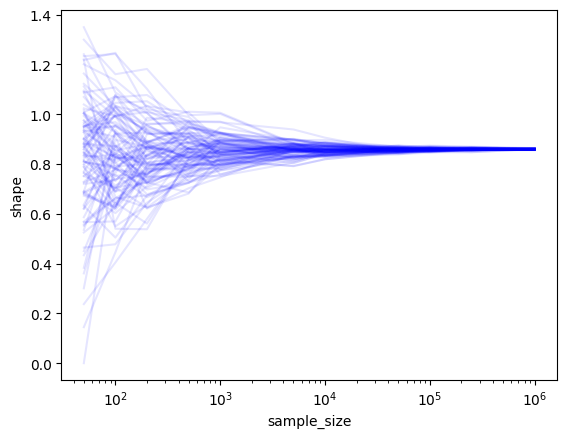

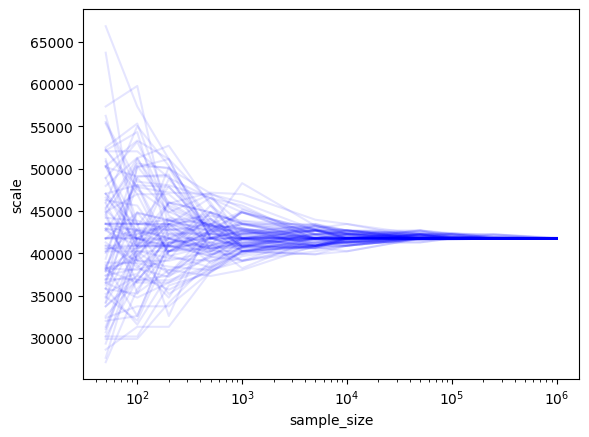

CPU times: user 2min 14s, sys: 29.8 s, total: 2min 43s
Wall time: 2min 43s


In [31]:
%%time
plot_parameters_by_sample_size(acs_employed, [50, 100, 200, 500, 1_000, 5_000, 10_000, 50_000, 100_000, 250_000, 1_000_000])

In [32]:
def plot_mean_median_pdfs_at_sample_size(values_df, sample_size, seed_seed=1234, **kwargs):
    rng = default_rng(seed_seed)
    seeds = rng.integers(0, 10_000_000, size=100)
    param_sets = []
    for seed in seeds:
        sample = values_df.sample(sample_size, random_state=seed)
        param_sets.append(params_from_mean_median(np.repeat(sample.income_2020_dollars, sample.PWGTP), clip_invalid_ratios=True))
    full_expanded = np.repeat(values_df.income_2020_dollars, values_df.PWGTP)
    plot_pdfs(full_expanded, param_sets, legend=False, style='g-', pdf_alpha=0.05, **kwargs)

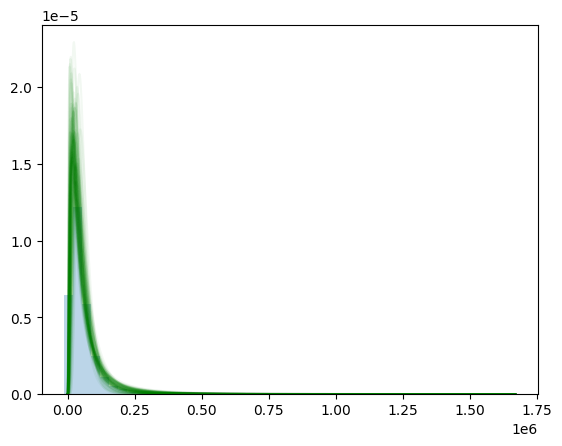

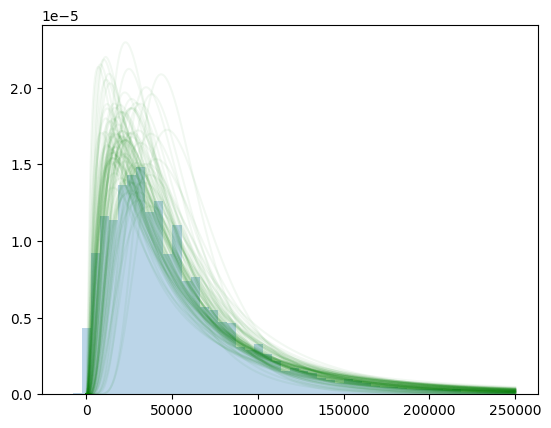

In [33]:
plot_mean_median_pdfs_at_sample_size(acs_employed, 100)

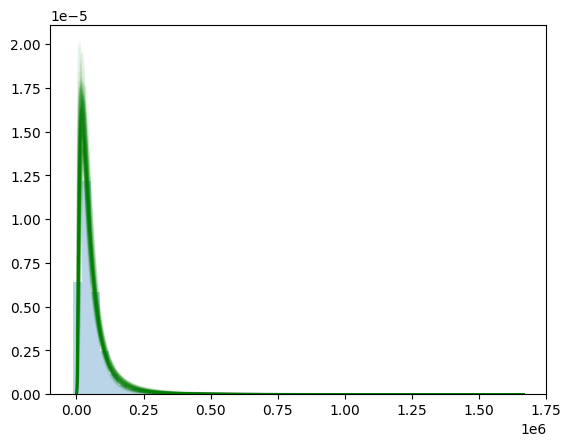

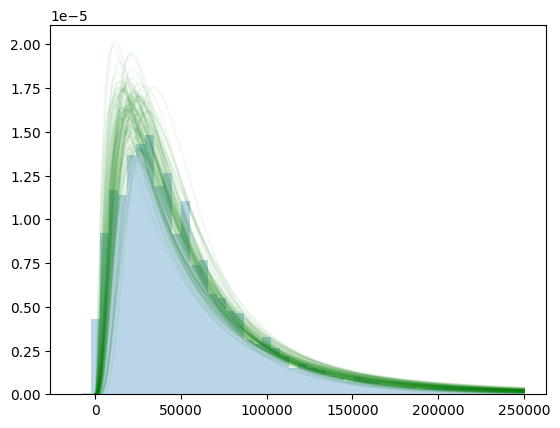

In [34]:
plot_mean_median_pdfs_at_sample_size(acs_employed, 250)

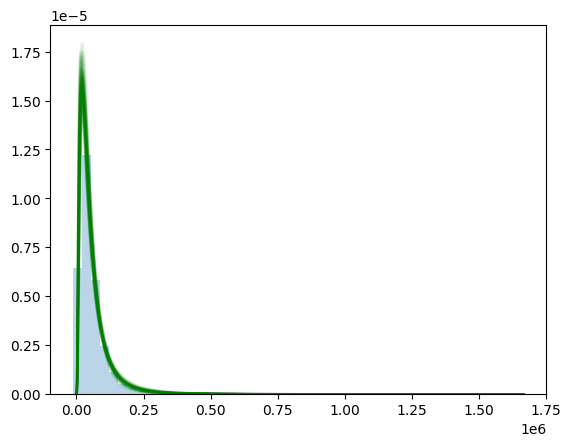

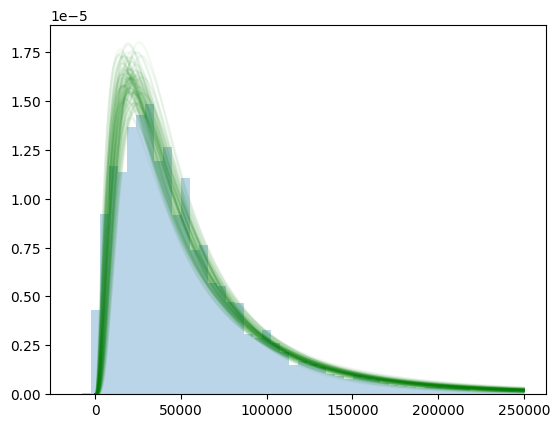

In [35]:
plot_mean_median_pdfs_at_sample_size(acs_employed, 500)

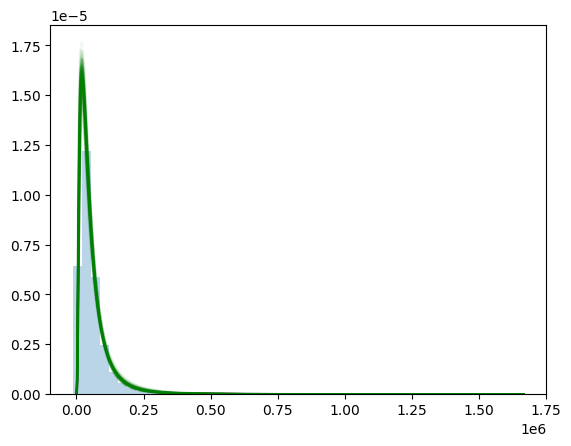

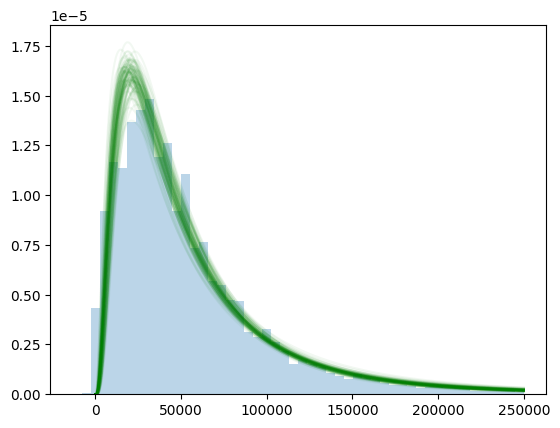

In [36]:
plot_mean_median_pdfs_at_sample_size(acs_employed, 1_000)

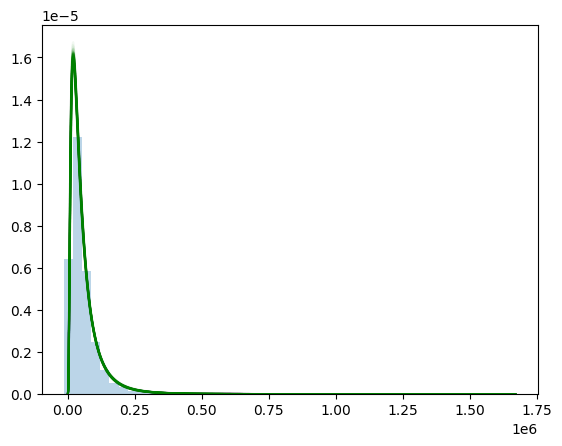

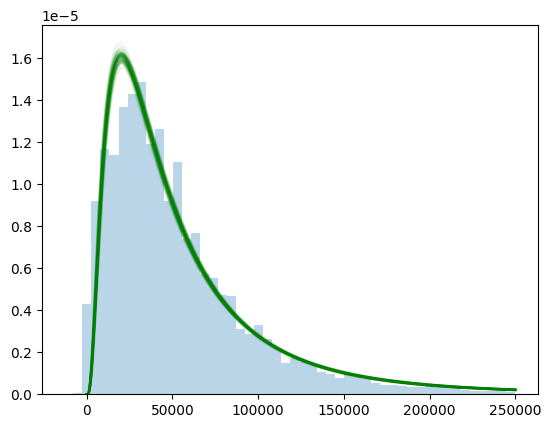

In [37]:
plot_mean_median_pdfs_at_sample_size(acs_employed, 10_000)

**My conclusion:** 1,000 looks like a reasonable cutoff.